In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import IPython.display as ipd
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from spafe.features.pncc import pncc

In [2]:
df = pd.read_csv('./coconut-maturity-dataset-wav-luar-kotak.csv')
df

,full_path,file_name,class_name
0,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg10a.wav,mature
1,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg10b.wav,mature
2,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg10c.wav,mature
3,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg11a.wav,mature
4,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg11b.wav,mature
...,...,...,...
175,./Sample-kelapa/data/cut_sample/tua/wav/tua8b.wav,tua8b.wav,overmature
176,./Sample-kelapa/data/cut_sample/tua/wav/tua8c.wav,tua8c.wav,overmature
177,./Sample-kelapa/data/cut_sample/tua/wav/tua9a.wav,tua9a.wav,overmature
178,./Sample-kelapa/data/cut_sample/tua/wav/tua9b.wav,tua9b.wav,overmature


In [3]:
def createWaveplot(data, sampleRate, maturity, color):
    plt.figure(figsize=(8,2))
    plt.title(f'Waveplot for {maturity} maturity', size = 15, pad = 20)
    librosa.display.waveshow(data, sr=sampleRate, alpha=0.5, color=color)
    plt.show()

def amplitude_envelope(signal, frame_size: int = 2048, hop_length: int = 512):
    """Calculate the amplitude envelope of a signal with a given frame size nad hop length."""
    amplitude_envelope = []
    
    # calculate amplitude envelope for each frame
    for i in range(0, len(signal), hop_length): 
        amplitude_envelope_current_frame = max(signal[i:i+frame_size]) 
        amplitude_envelope.append(amplitude_envelope_current_frame)
    
    return np.array(amplitude_envelope)

In [4]:
pnccs = []
mfccs = []
pncc_vectors = []
mfcc_vectors = []
zcr = []
ae = []
rmse = []

for filename in df['full_path'].values:
    wavSig, sampRate = librosa.load(filename)
    pncc_result = pncc(wavSig, fs=sampRate)
    mfcc_result = librosa.feature.mfcc(y=wavSig, sr=sampRate)
    pnccs.append(pncc_result)
    mfccs.append(mfcc_result)
    pncc_vectors.append(pncc_result.shape)
    mfcc_vectors.append(mfcc_result.shape)
    ae_result = amplitude_envelope(wavSig)
    zcr_result = librosa.feature.zero_crossing_rate(wavSig)
    rmse_result = librosa.feature.rms(y=wavSig)
    ae.append(ae_result)
    zcr.append(zcr_result[0])
    rmse.append(rmse_result[0])

d:\Cool Yeah\Semester 118\coconut-maturity-classification\envSkripsi\lib\site-packages\spafe\features\pncc.py:169: RuntimeWarning: invalid value encountered in double_scalars
  [R_tilde[m, lprime] / Q_tilde[m, lprime] for lprime in range(l1, l2)]
d:\Cool Yeah\Semester 118\coconut-maturity-classification\envSkripsi\lib\site-packages\spafe\features\pncc.py:169: RuntimeWarning: divide by zero encountered in double_scalars
  [R_tilde[m, lprime] / Q_tilde[m, lprime] for lprime in range(l1, l2)]
d:\Cool Yeah\Semester 118\coconut-maturity-classification\envSkripsi\lib\site-packages\spafe\features\pncc.py:437: RuntimeWarning: invalid value encountered in multiply
  T = P * S_tilde


In [5]:
df['PNCC-feature'] = pnccs
df['PNCC-feature-size'] = pncc_vectors
df['MFCC-feature'] = mfccs
df['MFCC-feature-size'] = mfcc_vectors
df['amplitude-envelope'] = ae
df['zero-crossing-rate'] = zcr
df['RMS-energy'] = rmse
df

,full_path,file_name,class_name,PNCC-feature,PNCC-feature-size,MFCC-feature,MFCC-feature-size,amplitude-envelope,zero-crossing-rate,RMS-energy
0,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg10a.wav,mature,"[[2.000098246886966, -0.32312278051968846, 0.0...","(98, 13)","[[-726.5902, -726.04486, -725.31476, -724.9084...","(20, 44)","[5.2741158e-05, 6.533848e-05, 6.533848e-05, 7....","[0.169921875, 0.2451171875, 0.322265625, 0.323...","[1.741442e-05, 2.2019052e-05, 2.6264723e-05, 2..."
1,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg10b.wav,mature,"[[2.03020507353705, -0.3081231693218535, 0.023...","(98, 13)","[[-660.823, -660.6598, -660.7989, -660.306, -6...","(20, 44)","[8.562851e-05, 0.000106699576, 0.000106699576,...","[0.1552734375, 0.2197265625, 0.2861328125, 0.2...","[1.9825766e-05, 2.5567619e-05, 3.1338837e-05, ..."
2,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg10c.wav,mature,"[[2.053201586789632, -0.30926271900245406, 0.0...","(98, 13)","[[-673.22833, -673.176, -673.22833, -672.8981,...","(20, 44)","[7.664046e-05, 7.664046e-05, 9.752976e-05, 9.7...","[0.1484375, 0.20947265625, 0.2802734375, 0.273...","[1.908695e-05, 2.4348914e-05, 2.868397e-05, 2...."
3,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg11a.wav,mature,"[[2.1524977561943794, -0.2745882742675701, -0....","(98, 13)","[[-703.6863, -698.70905, -670.14465, -658.5095...","(20, 44)","[0.0004190257, 0.0004190257, 0.0004190257, 0.0...","[0.11865234375, 0.1572265625, 0.17919921875, 0...","[2.8227014e-05, 7.7885874e-05, 0.00011563334, ..."
4,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg11b.wav,mature,"[[2.085433271523342, -0.3482630528427392, -0.0...","(98, 13)","[[-690.01776, -689.66144, -689.2191, -689.339,...","(20, 44)","[6.3666506e-05, 6.1336046e-05, 5.338081e-05, 5...","[0.15625, 0.23095703125, 0.30322265625, 0.3066...","[2.0658814e-05, 2.5298703e-05, 2.9047435e-05, ..."
...,...,...,...,...,...,...,...,...,...,...
175,./Sample-kelapa/data/cut_sample/tua/wav/tua8b.wav,tua8b.wav,overmature,"[[2.0537136283217605, -0.31411837379075197, 0....","(98, 13)","[[-714.5778, -713.85254, -713.69366, -705.8138...","(20, 44)","[0.00012795377, 0.0001551585, 0.00016831578, 0...","[0.16064453125, 0.23095703125, 0.27490234375, ...","[1.839841e-05, 2.621859e-05, 3.6141188e-05, 4...."
176,./Sample-kelapa/data/cut_sample/tua/wav/tua8c.wav,tua8c.wav,overmature,"[[1.9822215851057952, -0.31483581060334237, 0....","(98, 13)","[[-712.34656, -712.0022, -712.6092, -712.62354...","(20, 44)","[3.748658e-05, 3.748658e-05, 3.748658e-05, 3.9...","[0.1845703125, 0.26416015625, 0.3564453125, 0....","[1.7385477e-05, 2.1367476e-05, 2.4571253e-05, ..."
177,./Sample-kelapa/data/cut_sample/tua/wav/tua9a.wav,tua9a.wav,overmature,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","(98, 13)","[[-689.2629, -689.2629, -689.2629, -689.2629, ...","(20, 44)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
178,./Sample-kelapa/data/cut_sample/tua/wav/tua9b.wav,tua9b.wav,overmature,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","(98, 13)","[[-677.02826, -677.02826, -677.02826, -677.028...","(20, 44)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [167]:
df.to_csv('extracted-features.csv', index=False)

In [6]:
df_cut = df[df['PNCC-feature'].apply(lambda x: not np.isnan(x).any())]
df_cut.reset_index(drop=True, inplace=True)
df_cut

,full_path,file_name,class_name,PNCC-feature,PNCC-feature-size,MFCC-feature,MFCC-feature-size,amplitude-envelope,zero-crossing-rate,RMS-energy
0,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg10a.wav,mature,"[[2.000098246886966, -0.32312278051968846, 0.0...","(98, 13)","[[-726.5902, -726.04486, -725.31476, -724.9084...","(20, 44)","[5.2741158e-05, 6.533848e-05, 6.533848e-05, 7....","[0.169921875, 0.2451171875, 0.322265625, 0.323...","[1.741442e-05, 2.2019052e-05, 2.6264723e-05, 2..."
1,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg10b.wav,mature,"[[2.03020507353705, -0.3081231693218535, 0.023...","(98, 13)","[[-660.823, -660.6598, -660.7989, -660.306, -6...","(20, 44)","[8.562851e-05, 0.000106699576, 0.000106699576,...","[0.1552734375, 0.2197265625, 0.2861328125, 0.2...","[1.9825766e-05, 2.5567619e-05, 3.1338837e-05, ..."
2,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg10c.wav,mature,"[[2.053201586789632, -0.30926271900245406, 0.0...","(98, 13)","[[-673.22833, -673.176, -673.22833, -672.8981,...","(20, 44)","[7.664046e-05, 7.664046e-05, 9.752976e-05, 9.7...","[0.1484375, 0.20947265625, 0.2802734375, 0.273...","[1.908695e-05, 2.4348914e-05, 2.868397e-05, 2...."
3,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg11a.wav,mature,"[[2.1524977561943794, -0.2745882742675701, -0....","(98, 13)","[[-703.6863, -698.70905, -670.14465, -658.5095...","(20, 44)","[0.0004190257, 0.0004190257, 0.0004190257, 0.0...","[0.11865234375, 0.1572265625, 0.17919921875, 0...","[2.8227014e-05, 7.7885874e-05, 0.00011563334, ..."
4,./Sample-kelapa/data/cut_sample/matang/wav/mtg...,mtg11b.wav,mature,"[[2.085433271523342, -0.3482630528427392, -0.0...","(98, 13)","[[-690.01776, -689.66144, -689.2191, -689.339,...","(20, 44)","[6.3666506e-05, 6.1336046e-05, 5.338081e-05, 5...","[0.15625, 0.23095703125, 0.30322265625, 0.3066...","[2.0658814e-05, 2.5298703e-05, 2.9047435e-05, ..."
...,...,...,...,...,...,...,...,...,...,...
134,./Sample-kelapa/data/cut_sample/tua/wav/tua2c.wav,tua2c.wav,overmature,"[[2.021531665614917, -0.32578074400792156, 0.0...","(98, 13)","[[-706.5763, -706.55695, -706.5829, -706.5764,...","(20, 44)","[4.4958317e-05, 4.4958317e-05, 5.7125806e-05, ...","[0.16796875, 0.2421875, 0.33203125, 0.33007812...","[1.7348988e-05, 2.1297352e-05, 2.4144223e-05, ..."
135,./Sample-kelapa/data/cut_sample/tua/wav/tua4a.wav,tua4a.wav,overmature,"[[2.1749682479502663, -0.36037524712967883, -0...","(98, 13)","[[-761.9785, -753.03973, -747.70654, -745.4355...","(20, 44)","[0.00015697465, 0.0001644985, 0.0001644985, 0....","[0.11376953125, 0.1689453125, 0.21630859375, 0...","[3.4832294e-05, 4.397031e-05, 5.5298387e-05, 5..."
136,./Sample-kelapa/data/cut_sample/tua/wav/tua8a.wav,tua8a.wav,overmature,"[[2.1839039600808268, -0.44852762948216335, 0....","(98, 13)","[[-723.2729, -720.58295, -724.2534, -725.74774...","(20, 44)","[0.00016171605, 0.00015997203, 8.671761e-05, 8...","[0.166015625, 0.24951171875, 0.33154296875, 0....","[3.8330938e-05, 4.2394706e-05, 4.485954e-05, 3..."
137,./Sample-kelapa/data/cut_sample/tua/wav/tua8b.wav,tua8b.wav,overmature,"[[2.0537136283217605, -0.31411837379075197, 0....","(98, 13)","[[-714.5778, -713.85254, -713.69366, -705.8138...","(20, 44)","[0.00012795377, 0.0001551585, 0.00016831578, 0...","[0.16064453125, 0.23095703125, 0.27490234375, ...","[1.839841e-05, 2.621859e-05, 3.6141188e-05, 4...."


In [8]:
df_cut.to_csv('extracted-features-cut.csv', index=False)

In [7]:
print(np.stack(df_cut['PNCC-feature'].values).shape)
print(np.stack(df_cut['MFCC-feature'].values).shape)
print(np.stack(df_cut['amplitude-envelope'].values).shape)
print(np.stack(df_cut['zero-crossing-rate'].values).shape)
print(np.stack(df_cut['RMS-energy'].values).shape)

(139, 98, 13)
(139, 20, 44)
(139, 44)
(139, 44)
(139, 44)


In [31]:
pncc_feature = np.stack(df_cut['PNCC-feature'].values)
mfcc_feature = np.stack(df_cut['MFCC-feature'].values)
ae_feature = np.stack(df_cut['amplitude-envelope'].values)
zcr_feature = np.stack(df_cut['zero-crossing-rate'].values)
rmse_feature = np.stack(df_cut['RMS-energy'].values)

X = np.concatenate((pncc_feature.reshape(139, -1),
                    mfcc_feature.reshape(139, -1),
                    ae_feature.reshape(139, -1),
                    zcr_feature.reshape(139, -1),
                    rmse_feature.reshape(139, -1)), axis=1)

In [32]:
X.shape

(139, 2286)

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

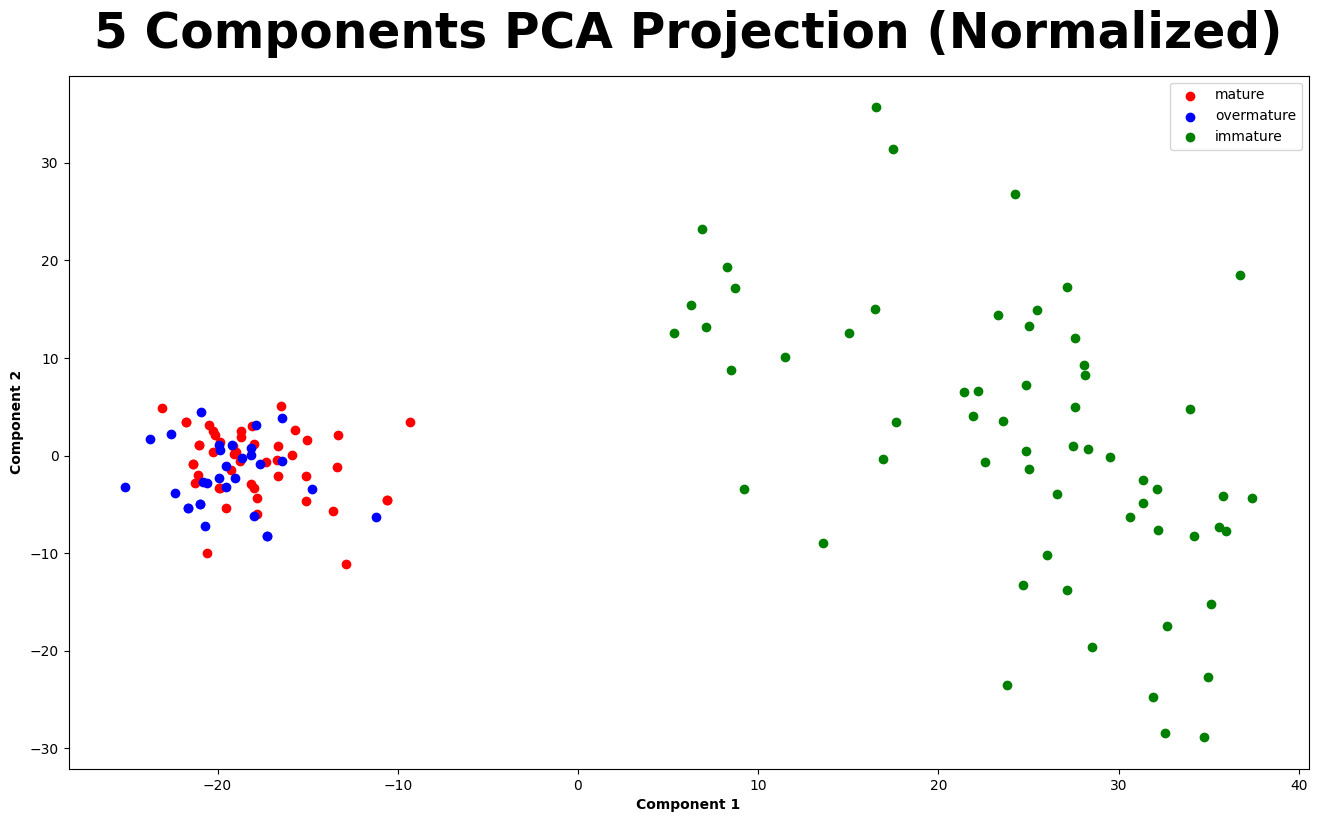

In [11]:
pca = PCA(n_components=5)
pca.fit(X_scaled)
pca_result = pca.transform(X_scaled)

labels = df_cut['class_name'].values.tolist()

# Create a dictionary to map labels to colors for plotting
label_colors = {'mature': 'red', 'immature': 'green', 'overmature': 'blue'}

x = pca_result[:, 0]
y = pca_result[:, 1]

unique_labels = set(labels)

fig, ax = plt.subplots(figsize=(16, 9))
for label in unique_labels:
    indices = np.where(np.array(labels) == label)
    ax.scatter(x[indices], y[indices], c=label_colors[label], label=label)

plt.title('5 Components PCA Projection (Normalized)', fontsize=35, pad=20, fontweight='bold')
plt.xlabel('Component 1', fontweight='bold')
plt.ylabel('Component 2', fontweight='bold')

# Add a legend
ax.legend()

# Show the plot
plt.show()

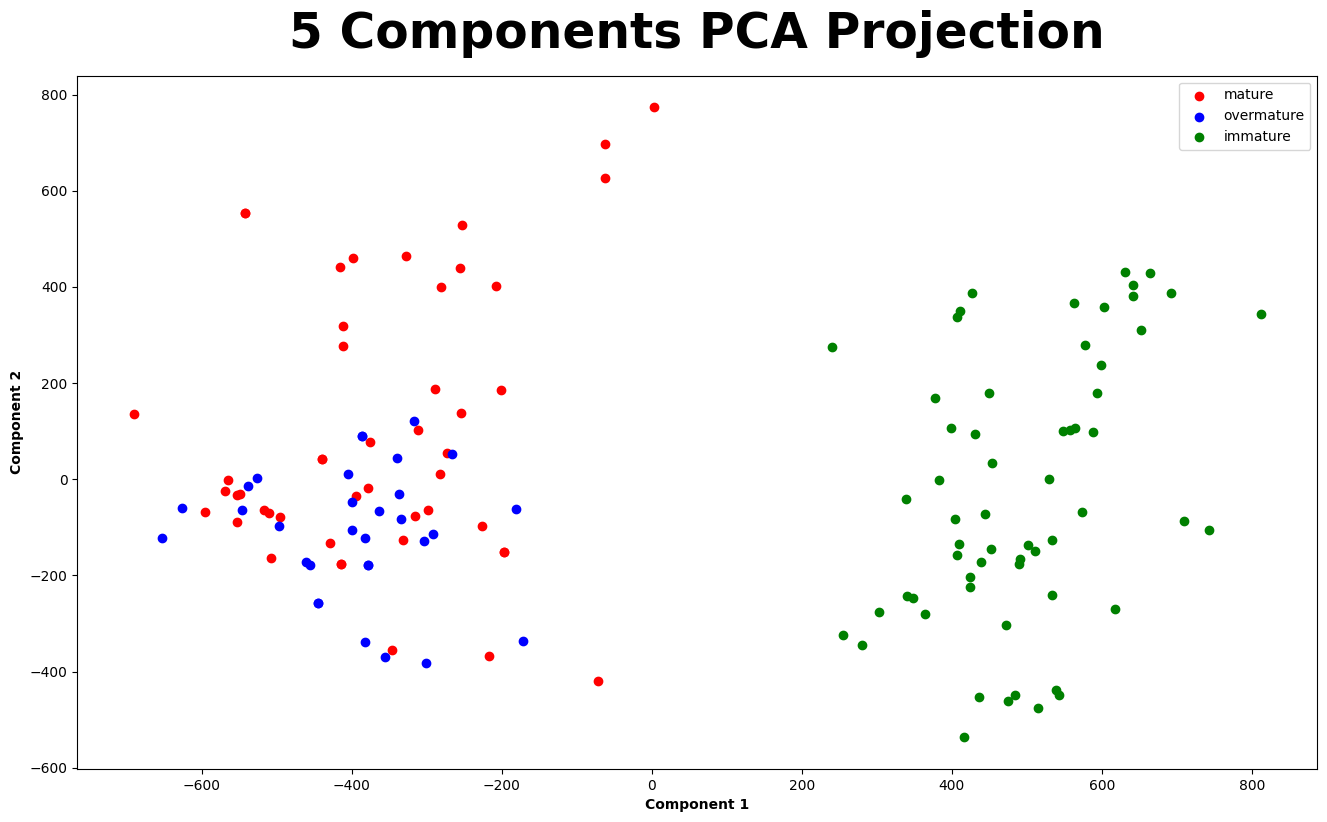

In [12]:
pca = PCA(n_components=5)
pca.fit(X)
pca_result = pca.transform(X)

labels = df_cut['class_name'].values.tolist()

# Create a dictionary to map labels to colors for plotting
label_colors = {'mature': 'red', 'immature': 'green', 'overmature': 'blue'}

x = pca_result[:, 0]
y = pca_result[:, 1]

unique_labels = set(labels)

fig, ax = plt.subplots(figsize=(16, 9))
for label in unique_labels:
    indices = np.where(np.array(labels) == label)
    ax.scatter(x[indices], y[indices], c=label_colors[label], label=label)

plt.title('5 Components PCA Projection', fontsize=35, pad=20, fontweight='bold')
plt.xlabel('Component 1', fontweight='bold')
plt.ylabel('Component 2', fontweight='bold')

# Add a legend
ax.legend()

# Show the plot
plt.show()

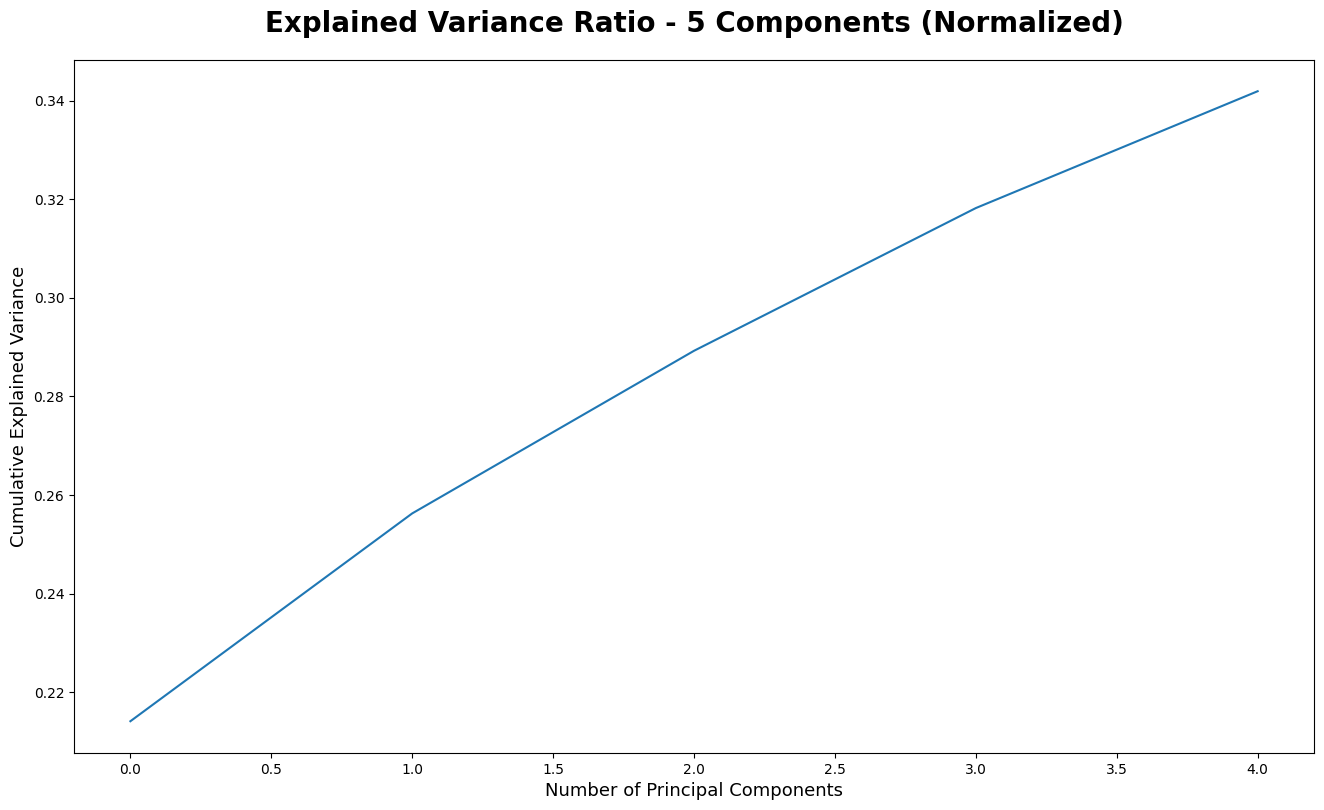

In [13]:
pca = PCA(n_components=5)
pca.fit(X_scaled)
pca_result = pca.transform(X_scaled)

plt.subplots(figsize = (16, 9))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components', fontsize=13)
plt.ylabel('Cumulative Explained Variance', fontsize=13)
plt.title('Explained Variance Ratio - 5 Components (Normalized)', fontsize=20, pad=20, fontweight='bold')
plt.show()

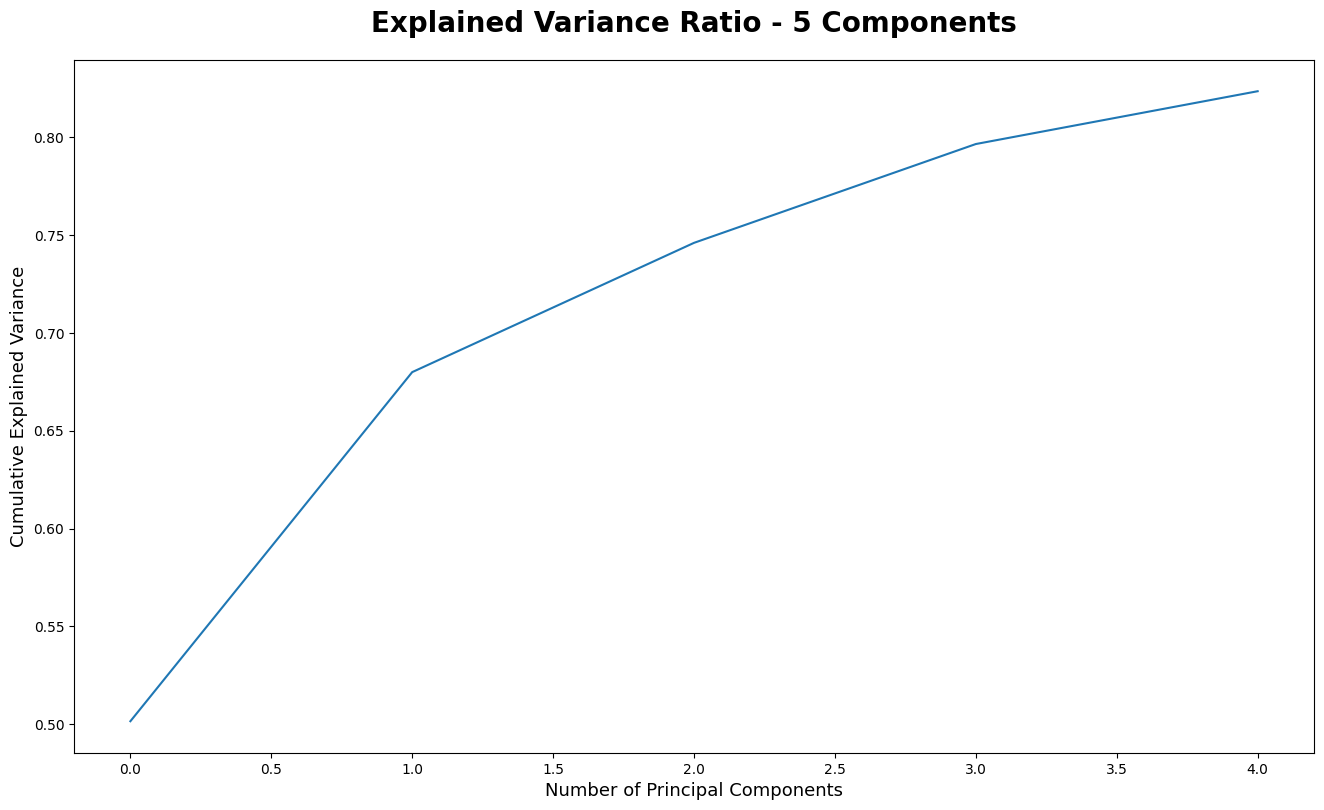

In [14]:
pca = PCA(n_components=5)
pca.fit(X)
pca_result = pca.transform(X)

plt.subplots(figsize = (16, 9))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components', fontsize=13)
plt.ylabel('Cumulative Explained Variance', fontsize=13)
plt.title('Explained Variance Ratio - 5 Components', fontsize=20, pad=20, fontweight='bold')
plt.show()

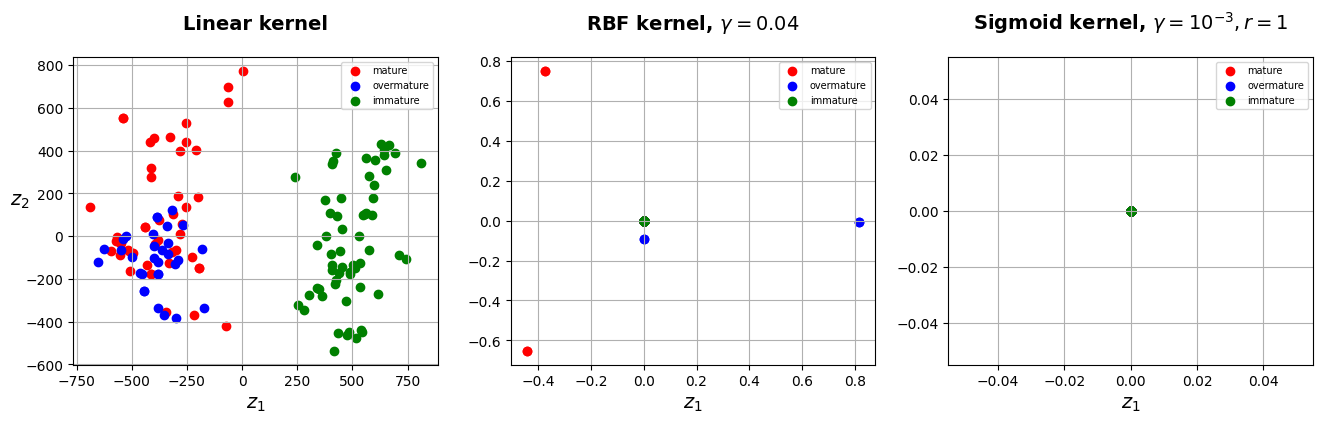

In [15]:
lin_pca = KernelPCA(n_components=5, kernel="linear")
rbf_pca = KernelPCA(n_components=5, kernel="rbf", gamma=0.0433)
sig_pca = KernelPCA(n_components=5, kernel="sigmoid", gamma=0.001)

unique_labels = set(labels)
label_colors = {'mature': 'red', 'immature': 'green', 'overmature': 'blue'}

plt.figure(figsize=(16, 4))
for subplot, pca, title in((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    reduced = pca.fit_transform(X)

    x = reduced[:, 0]
    y = reduced[:, 1]

    plt.subplot(subplot)
    for label in unique_labels:
        indices = np.where(np.array(labels) == label)
        plt.scatter(x[indices], y[indices], c=label_colors[label], label=label)

    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.xlabel("$z_1$", fontsize=14)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=14, rotation=0)
    plt.legend(fontsize=7)
    plt.grid()
plt.show()

In [30]:
# Create an instance of OneHotEncoder
labels = df_cut['class_name'].values
one_hot_encoder = OneHotEncoder()

# Fit and transform the labels
encoded_labels = one_hot_encoder.fit_transform(labels.reshape(-1, 1)).toarray()

In [35]:
print(f'ukuran data fitur : {encoded_labels.shape}')
print(f'ukuran data label : {X.shape}')

ukuran data fitur : (139, 3)
ukuran data label : (139, 2286)


In [45]:
x_train, x_test, y_train, y_test = train_test_split(X, encoded_labels, train_size=0.8, random_state=4, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((111, 2286), (111, 3), (28, 2286), (28, 3))

In [46]:
x_train = np.expand_dims(x_train,axis=2)
x_test = np.expand_dims(x_test,axis=2)
print(f"Ukuran data train\t: {x_train.shape}")
print(f"Ukuran data test\t: {x_test.shape}")

Ukuran data train	: (111, 2286, 1)
Ukuran data test	: (28, 2286, 1)


In [52]:
x_train.shape[2]

1

In [51]:
model = Sequential()
model.add(Bidirectional(LSTM(units=128,
                             dropout=0.05,
                             recurrent_dropout=0.20,
                             return_sequences=True),
                             input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Flatten())
model.add(Dense(units=3, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 2286, 256)        133120    
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 2286, 128)         32896     
                                                                 
 dropout_1 (Dropout)         (None, 2286, 128)         0         
                                                                 
 dense_6 (Dense)             (None, 2286, 128)         16512     
                                                                 
 dense_7 (Dense)             (None, 2286, 64)          8256      
                                                                 
 dense_8 (Dense)             (None, 2286, 64)          4160      
                                                      

In [53]:
LSTM_model = model.fit(x_train, y_train, batch_size=12, epochs=100, validation_data=(x_test, y_test))

Epoch 1/1000
 1/10 [==>...........................] - ETA: 6:56 - loss: 1.0826 - accuracy: 0.5000

In [ ]:
modelResults = model.evaluate(x_test, y_test)

In [ ]:
print(f"LOSS\t\t: {round(modelResults[0]*100,2)}%")
print(f"ACCURACY\t: {round(modelResults[1]*100,2)}%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = LSTM_model.history['accuracy']
train_loss = LSTM_model.history['loss']
test_acc = LSTM_model.history['val_accuracy']
test_loss = LSTM_model.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
pred_test = model.predict(x_test)
y_pred = one_hot_encoder.inverse_transform(pred_test)
y_test = one_hot_encoder.inverse_transform(y_test)
df_predict = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df_predict['Predicted Labels'] = y_pred.flatten()
df_predict['Actual Labels'] = y_test.flatten()
df_predict.head(10)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in one_hot_encoder.categories_] , columns = [i for i in one_hot_encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=10)
plt.ylabel('Actual Labels', size=10)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
model.save('LSTM_model')